We will first load the data and scale it

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df_train = pd.read_csv('./dataset/train.csv')
df_val = pd.read_csv('./dataset/val.csv')
df_test = pd.read_csv('./dataset/test.csv')

scaler_r = MinMaxScaler()
scaler_c = MinMaxScaler()

scaler_r.fit(df_train[['registered']])
scaler_c.fit(df_train[['casual']])


df_train['registered_s'] = scaler_r.transform(df_train[['registered']])
df_val['registered_s'] = scaler_r.transform(df_val[['registered']])
df_test['registered_s'] = scaler_r.transform(df_test[['registered']])

df_train['casual_s'] = scaler_c.transform(df_train[['casual']])
df_val['casual_s'] = scaler_c.transform(df_val[['casual']])
df_test['casual_s'] = scaler_c.transform(df_test[['casual']])

In [2]:
df_train.head()

,Unnamed: 0,season,workingday,weathersit,temp,hum,casual,registered,day_sin,day_cos,week_sin,week_cos,registered_s,casual_s
0,0,1,0,1,0.24,0.81,3,13,0.000000,1.000000,-0.781831,0.62349,0.016332,0.008174
1,1,1,0,1,0.22,0.80,8,32,0.258819,0.965926,-0.781831,0.62349,0.040201,0.021798
2,2,1,0,1,0.22,0.80,5,27,0.500000,0.866025,-0.781831,0.62349,0.033920,0.013624
3,3,1,0,1,0.24,0.75,3,10,0.707107,0.707107,-0.781831,0.62349,0.012563,0.008174
4,4,1,0,1,0.24,0.75,0,1,0.866025,0.500000,-0.781831,0.62349,0.001256,0.000000


In [3]:
df_train.drop(['Unnamed: 0','casual','registered'],axis=1,inplace=True)
df_val.drop(['Unnamed: 0','casual','registered'],axis=1,inplace=True)
df_test.drop(['Unnamed: 0','casual','registered'],axis=1,inplace=True)

df_train.head()

,season,workingday,weathersit,temp,hum,day_sin,day_cos,week_sin,week_cos,registered_s,casual_s
0,1,0,1,0.24,0.81,0.000000,1.000000,-0.781831,0.62349,0.016332,0.008174
1,1,0,1,0.22,0.80,0.258819,0.965926,-0.781831,0.62349,0.040201,0.021798
2,1,0,1,0.22,0.80,0.500000,0.866025,-0.781831,0.62349,0.033920,0.013624
3,1,0,1,0.24,0.75,0.707107,0.707107,-0.781831,0.62349,0.012563,0.008174
4,1,0,1,0.24,0.75,0.866025,0.500000,-0.781831,0.62349,0.001256,0.000000


Now Lets create the dataset from the tabular data to work with our model

In [4]:
import numpy as np


def create_dataset(data, feature_columns, target_columns, lookback_window, horizon, shift):
    """
    Transforms a time series DataFrame into input-target pairs for a deep learning model.

    Args:
        data (pd.DataFrame): The input DataFrame.
        feature_columns (list): List of column names to use as input features (X).
        target_columns (list): List of column names to use as target variables (Y).
        lookback_window (int): The number of past time steps to use as input (X).
        horizon (int): The number of future time steps to predict (Y).
        shift (int): The number of steps to shift the window for each new sample.

    Returns:
        tuple: A tuple containing two NumPy arrays, X (inputs) and Y (targets).
    """
    X, Y = [], []
    for i in range(0, len(data) - lookback_window - horizon + 1, shift):
        # Extract the input features (X) for the current window
        x_start = i
        x_end = i + lookback_window
        X.append(data.iloc[x_start:x_end][feature_columns].values)

        # Extract the target variables (Y) for the forecast horizon
        y_start = i + lookback_window
        y_end = y_start + horizon
        Y.append(data.iloc[y_start:y_end][target_columns].values)
    
    return np.array(X), np.array(Y)


In [5]:
#  Define key parameters
LOOKBACK_WINDOW = 24  # last 24 hours of data as input
FORECAST_HORIZON = 3 # Predict the next 3 hours
SHIFT = 1            # Move the window by 1 hour for each new sample

# ----------------------------------------------------
# The columns model use to learn the patterns.

feature_columns = [
    'season', 'workingday', 'weathersit', 'temp', 'hum',
    'day_sin', 'day_cos', 'week_sin', 'week_cos'
]

# The columns model will try to predict.
target_columns = ['casual_s', 'registered_s']



Lets' first create the training dataset and have a look at it

In [6]:
X_train, Y_train = create_dataset(df_train, feature_columns, target_columns, LOOKBACK_WINDOW, FORECAST_HORIZON, SHIFT)


print(f"Shape of Input (X): {X_train.shape}")       # shape will be in the following order
print(f"Shape of Target (Y): {Y_train.shape}")      # [Number of Samples, Window, Number of Features]

# Now let's have a look at the first data sample
print("\n--- Example of First Sample ---")
print("Input X (first window, all features):")
print(X_train[0])
print("\nTarget Y (next 3 hours, only targets):")
print(Y_train[0])

Shape of Input (X): (13877, 24, 9)
Shape of Target (Y): (13877, 3, 2)

--- Example of First Sample ---
Input X (first window, all features):
[[ 1.00000000e+00  0.00000000e+00  1.00000000e+00  2.40000000e-01
   8.10000000e-01  0.00000000e+00  1.00000000e+00 -7.81831482e-01
   6.23489802e-01]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00  2.20000000e-01
   8.00000000e-01  2.58819045e-01  9.65925826e-01 -7.81831482e-01
   6.23489802e-01]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00  2.20000000e-01
   8.00000000e-01  5.00000000e-01  8.66025404e-01 -7.81831482e-01
   6.23489802e-01]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00  2.40000000e-01
   7.50000000e-01  7.07106781e-01  7.07106781e-01 -7.81831482e-01
   6.23489802e-01]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00  2.40000000e-01
   7.50000000e-01  8.66025404e-01  5.00000000e-01 -7.81831482e-01
   6.23489802e-01]
 [ 1.00000000e+00  0.00000000e+00  2.00000000e+00  2.40000000e-01
   7.50000000e-01  9.65925826e-01  2.5

In [7]:
X_val, Y_val = create_dataset(df_val, feature_columns, target_columns, LOOKBACK_WINDOW, FORECAST_HORIZON, SHIFT)
X_test, Y_test = create_dataset(df_test, feature_columns, target_columns, LOOKBACK_WINDOW, FORECAST_HORIZON, SHIFT)


Now Let's create dataloader which will serve the above created data to our models for training and testing.

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Convert NumPy arrays to PyTorch Tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(Y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(Y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(Y_test)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Now let's Design our model.  
We will create two models. one solely based on LSTM architecture and another one combining CNN with LSTM.

In [9]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, output_size):
        super(LSTMForecaster,self).__init__()

        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layer = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        lstm_out,(h_n,c_n) = self.lstm(x)
        out = lstm_out[:,-1,:]  # Getting the output for the final step.
        out = self.fc(out)
        out = out.view(x.size(0),-1,2) #changing the shape of the output to (batch_size,horizen,targets)
        return out
    

class CNN_LSTMForecaster(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, output_size, cnn_filters=32, kernel_size=3):
        super(CNN_LSTMForecaster, self).__init__()
        
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.cnn_filters = cnn_filters
        self.kernel_size = kernel_size

        self.cnn = nn.Sequential(
            # Input shape: (batch_size, num_features, lookback_window)
            nn.Conv1d(
                in_channels=num_features, 
                out_channels=self.cnn_filters, 
                kernel_size=self.kernel_size,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        self.lstm = nn.LSTM(
            input_size=self.cnn_filters,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self,x):

        #shape of x is (batch_size, lookback_window, num_features)
        x = x.permute(0, 2, 1) # for the convolution we need shape of x to be (batch_size, num_features, lookback_window)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1) #changing the shape back for LSTM
        lstm_out, (h_n, c_n) = self.lstm(cnn_out)
        out = lstm_out[:,-1,:]  # Getting the output for the final step.
        out = self.fc(out)
        out = out.view(x.size(0), -1, 2)
        
        return out



Let's initialize the both models.

In [16]:
BATCH_SIZE = 64
LOOKBACK_WINDOW = 24
NUM_FEATURES = 9 # Features we use to predict future
FORECAST_HORIZON = 3
NUM_TARGETS = 2 # casual and registered

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lstm_model = LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=64,
        num_layers=1,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )

cnn_lstm_model = CNN_LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=50,
        num_layers=2,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )

In [17]:
from tqdm import tqdm

def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device='cpu', name=''):
    """
    Trains and validates a time series forecasting model.

    Args:
        model (nn.Module): The forecasting model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        loss_fn (nn.Module): The loss function (e.g., MSELoss).
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        epochs (int): The number of training epochs.
        device (str): The device to run the training on ('cpu' or 'cuda').
    """
    best_val_loss = float('inf')
    best_model_state = None

    model.to(device)

    for epoch in range(epochs):
        # --- Training Loop ---
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            optimizer.zero_grad() # Reset gradients
            
            inputs,targets = batch
            inputs=inputs.to(device)
            targets=targets.to(device)

            output = model(inputs)
            
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * targets.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)

        # --- Validation Loop ---
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} Validating"):
                optimizer.zero_grad() # Reset gradients
                
                inputs,targets = batch
                inputs=inputs.to(device)
                targets=targets.to(device)

                output = model(inputs)
                
                loss = loss_fn(output, targets)
                
                val_loss += loss.item() * targets.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Check if current validation loss is the best so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save the model state dictionary
            best_model_state = model.state_dict()
            print("Validation loss improved. Saving best model state.")
    
    if best_model_state:
        torch.save(best_model_state, './models/'+name+'_best.pth') # Save the best model
        print("Training complete. models saved to models/")
    else:
        print("Training complete. Could not save best model state.")
    

In [18]:
model = lstm_model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

print("\nStarting model training...")
train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=15, 
    device=device,
    name='lstm_L1'
)

lstm_model=model


Starting model training...


Epoch 1/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 635.13it/s]


Epoch 1/15: Train Loss: 0.0613, Val Loss: 0.0862
Validation loss improved. Saving best model state.


Epoch 2/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 800.73it/s]


Epoch 2/15: Train Loss: 0.0562, Val Loss: 0.0726
Validation loss improved. Saving best model state.


Epoch 3/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 851.29it/s]


Epoch 3/15: Train Loss: 0.0511, Val Loss: 0.0656
Validation loss improved. Saving best model state.


Epoch 4/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 820.79it/s]


Epoch 4/15: Train Loss: 0.0494, Val Loss: 0.0623
Validation loss improved. Saving best model state.


Epoch 5/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 805.55it/s]


Epoch 5/15: Train Loss: 0.0475, Val Loss: 0.0603
Validation loss improved. Saving best model state.


Epoch 6/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 891.59it/s]


Epoch 6/15: Train Loss: 0.0448, Val Loss: 0.0564
Validation loss improved. Saving best model state.


Epoch 7/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 778.91it/s]


Epoch 7/15: Train Loss: 0.0440, Val Loss: 0.0554
Validation loss improved. Saving best model state.


Epoch 8/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 822.60it/s]


Epoch 8/15: Train Loss: 0.0431, Val Loss: 0.0537
Validation loss improved. Saving best model state.


Epoch 9/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 904.91it/s]


Epoch 9/15: Train Loss: 0.0424, Val Loss: 0.0517
Validation loss improved. Saving best model state.


Epoch 10/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 837.71it/s]


Epoch 10/15: Train Loss: 0.0419, Val Loss: 0.0501
Validation loss improved. Saving best model state.


Epoch 11/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 485.47it/s]


Epoch 11/15: Train Loss: 0.0415, Val Loss: 0.0496
Validation loss improved. Saving best model state.


Epoch 12/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 918.76it/s]


Epoch 12/15: Train Loss: 0.0411, Val Loss: 0.0494
Validation loss improved. Saving best model state.


Epoch 13/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 802.17it/s]


Epoch 13/15: Train Loss: 0.0407, Val Loss: 0.0494
Validation loss improved. Saving best model state.


Epoch 14/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 896.67it/s]


Epoch 14/15: Train Loss: 0.0404, Val Loss: 0.0490
Validation loss improved. Saving best model state.


Epoch 15/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 897.86it/s]

Epoch 15/15: Train Loss: 0.0399, Val Loss: 0.0486
Validation loss improved. Saving best model state.
Training complete. models saved to models/


In [19]:
model = cnn_lstm_model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

print("\nStarting model training...")
train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=15,
    device=device,
    name='cnn_lstm_L1'
)

cnn_lstm_model=model


Starting model training...


Epoch 1/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 646.07it/s]


Epoch 1/15: Train Loss: 0.0617, Val Loss: 0.0840
Validation loss improved. Saving best model state.


Epoch 2/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 676.58it/s]


Epoch 2/15: Train Loss: 0.0523, Val Loss: 0.0631
Validation loss improved. Saving best model state.


Epoch 3/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 608.27it/s]


Epoch 3/15: Train Loss: 0.0451, Val Loss: 0.0527
Validation loss improved. Saving best model state.


Epoch 4/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 612.68it/s]


Epoch 4/15: Train Loss: 0.0431, Val Loss: 0.0505
Validation loss improved. Saving best model state.


Epoch 5/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 622.96it/s]


Epoch 5/15: Train Loss: 0.0426, Val Loss: 0.0502
Validation loss improved. Saving best model state.


Epoch 6/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 627.41it/s]


Epoch 6/15: Train Loss: 0.0422, Val Loss: 0.0496
Validation loss improved. Saving best model state.


Epoch 7/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 594.49it/s]


Epoch 7/15: Train Loss: 0.0418, Val Loss: 0.0501


Epoch 8/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 654.35it/s]


Epoch 8/15: Train Loss: 0.0417, Val Loss: 0.0498


Epoch 9/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 625.70it/s]


Epoch 9/15: Train Loss: 0.0415, Val Loss: 0.0490
Validation loss improved. Saving best model state.


Epoch 10/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 651.59it/s]


Epoch 10/15: Train Loss: 0.0413, Val Loss: 0.0487
Validation loss improved. Saving best model state.


Epoch 11/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 586.37it/s]


Epoch 11/15: Train Loss: 0.0410, Val Loss: 0.0489


Epoch 12/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 618.66it/s]


Epoch 12/15: Train Loss: 0.0407, Val Loss: 0.0486
Validation loss improved. Saving best model state.


Epoch 13/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 662.71it/s]


Epoch 13/15: Train Loss: 0.0402, Val Loss: 0.0481
Validation loss improved. Saving best model state.


Epoch 14/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 636.44it/s]


Epoch 14/15: Train Loss: 0.0396, Val Loss: 0.0480
Validation loss improved. Saving best model state.


Epoch 15/15 Validating: 100%|██████████| 54/54 [00:00<00:00, 655.00it/s]

Epoch 15/15: Train Loss: 0.0391, Val Loss: 0.0478
Validation loss improved. Saving best model state.
Training complete. models saved to models/


Now we need to evaluate the models on our test set

In [20]:
def evaluate_model(model, test_loader, loss_fn, casual_scaler, registered_scaler, device='cpu'):
    """
    Evaluates the model on the test set and returns predictions and actual values.

    Args:
        model (nn.Module): The trained forecasting model.
        test_loader (DataLoader): DataLoader for the test data.
        loss_fn (nn.Module): The loss function (e.g., MSELoss).
        casual_scaler: The scaler fitted on the casual count training data.
        registered_scaler: The scaler fitted on the registered count training data.
        device (str): The device to run the evaluation on ('cpu' or 'cuda').

    Returns:
        tuple: A tuple containing denormalized predictions and actual values.
    """
    model.eval()
    model.to(device)
    
    test_loss = 0.0
    all_preds_scaled, all_actuals_scaled = [], []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs,targets = batch
            inputs=inputs.to(device)
            targets=targets.to(device)

            output = model(inputs)
            
            loss = loss_fn(output, targets)
            test_loss += loss.item() * targets.size(0)
            
            all_preds_scaled.append(output.cpu().numpy())
            all_actuals_scaled.append(targets.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"\nAverage Test Loss (Scaled MSE): {avg_test_loss:.4f}")

    print('outputs shape: ', output.shape)
    print("This should be Batch x Horizon x Feature")
    # Concatenate all batches
    all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
    all_actuals_scaled = np.concatenate(all_actuals_scaled, axis=0)
    print('Concatenated shape: ', all_preds_scaled.shape)
    # Denormalize the predictions and actuals
    # Note: We need to reshape for the scaler, then reshape back
    
    # Denormalize Casual predictions and actuals
    casual_preds_scaled = all_preds_scaled[:, :, 0]
    casual_preds = casual_scaler.inverse_transform(casual_preds_scaled.reshape(-1, 1)).reshape(casual_preds_scaled.shape)
    
    casual_actuals_scaled = all_actuals_scaled[:, :, 0]
    casual_actuals = casual_scaler.inverse_transform(casual_actuals_scaled.reshape(-1, 1)).reshape(casual_actuals_scaled.shape)
    
    # Denormalize Registered predictions and actuals
    registered_preds_scaled = all_preds_scaled[:, :, 1]
    registered_preds = registered_scaler.inverse_transform(registered_preds_scaled.reshape(-1, 1)).reshape(registered_preds_scaled.shape)
    
    registered_actuals_scaled = all_actuals_scaled[:, :, 1]
    registered_actuals = registered_scaler.inverse_transform(registered_actuals_scaled.reshape(-1, 1)).reshape(registered_actuals_scaled.shape)
    print('After Transform rgistered shape: ', registered_actuals_scaled.shape)
    return (casual_preds, registered_preds), (casual_actuals, registered_actuals)


Lets Load our saved models from training.

In [21]:
model_1 = LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=64,
        num_layers=1,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )

model_2 = CNN_LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=50,
        num_layers=2,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )

model_3 = CNN_LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=50,
        num_layers=2,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )

try:
    model_1.load_state_dict(torch.load('models/lstm_L1_best.pth', map_location=device))
    model_2.load_state_dict(torch.load('models/cnn_lstm_L1_best.pth', map_location=device))
    model_2.load_state_dict(torch.load('models/cnn_lstm_best.pth', map_location=device))
    print("Successfully loaded 'best_model.pth'.")
except FileNotFoundError:
    print("Error: 'best_model.pth' not found. Please train the model first.")
    exit()

Successfully loaded 'best_model.pth'.


In [22]:
preds_1, actuals_1 = evaluate_model(
        model=model_1,
        test_loader=test_loader,
        loss_fn=nn.L1Loss(),
        casual_scaler=scaler_c,
        registered_scaler=scaler_r,
        device=device
    )

Testing: 100%|██████████| 54/54 [00:00<00:00, 384.49it/s]


Average Test Loss (Scaled MSE): 0.0657
outputs shape:  torch.Size([17, 3, 2])
This should be Batch x Horizon x Feature
Concatenated shape:  (1713, 3, 2)
After Transform rgistered shape:  (1713, 3)


In [23]:
preds_2, actuals_2 = evaluate_model(
        model=model_2,
        test_loader=test_loader,
        loss_fn=nn.L1Loss(),
        casual_scaler=scaler_c,
        registered_scaler=scaler_r,
        device=device
    )

Testing: 100%|██████████| 54/54 [00:00<00:00, 349.58it/s]


Average Test Loss (Scaled MSE): 0.0649
outputs shape:  torch.Size([17, 3, 2])
This should be Batch x Horizon x Feature
Concatenated shape:  (1713, 3, 2)
After Transform rgistered shape:  (1713, 3)


In [24]:
preds_3, actuals_3 = evaluate_model(
        model=model_3,
        test_loader=test_loader,
        loss_fn=nn.L1Loss(),
        casual_scaler=scaler_c,
        registered_scaler=scaler_r,
        device=device
    )

Testing: 100%|██████████| 54/54 [00:00<00:00, 284.68it/s]


Average Test Loss (Scaled MSE): 0.1871
outputs shape:  torch.Size([17, 3, 2])
This should be Batch x Horizon x Feature
Concatenated shape:  (1713, 3, 2)
After Transform rgistered shape:  (1713, 3)


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(preds, actuals, sample_indices=[0,1,2,3], title="Prediction vs. Actuals"):
    """
    Plots the predicted vs. actual values for a specific test sample.
    """
    casual_preds, registered_preds = preds
    casual_actuals, registered_actuals = actuals
    
    plt.figure(figsize=(12, 4))
    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)

    fig.suptitle(title, fontsize=16, fontweight='bold')
    for i in range(2):
        for j in range(4):
            ax = axs[i, j]
            ax.plot(actuals[i][sample_indices[j]], color='blue', marker='o')
            ax.plot(preds[i][sample_indices[j]], color='red', linestyle='--', marker='x')
            ax.set_title(f'{sample_indices[j]}')
            ax.grid(True)
    row1_title_text = fig.text(0.5, 0.9, 'Casual Users', ha='center', va='center', fontsize=14)
    row2_title_text = fig.text(0.5, 0.45, 'Registered Users', ha='center', va='center', fontsize=14)

    # Plot Casual users

    plt.show()

In [32]:
preds = [preds_1,preds_2,preds_3]
actuals= [actuals_1,actuals_2,actuals_3]


--- Model Performance on Test Set (Denormalized) ---
Casual Users - MAE: 20.58, RMSE: 33.53
Registered Users - MAE: 59.92, RMSE: 92.46


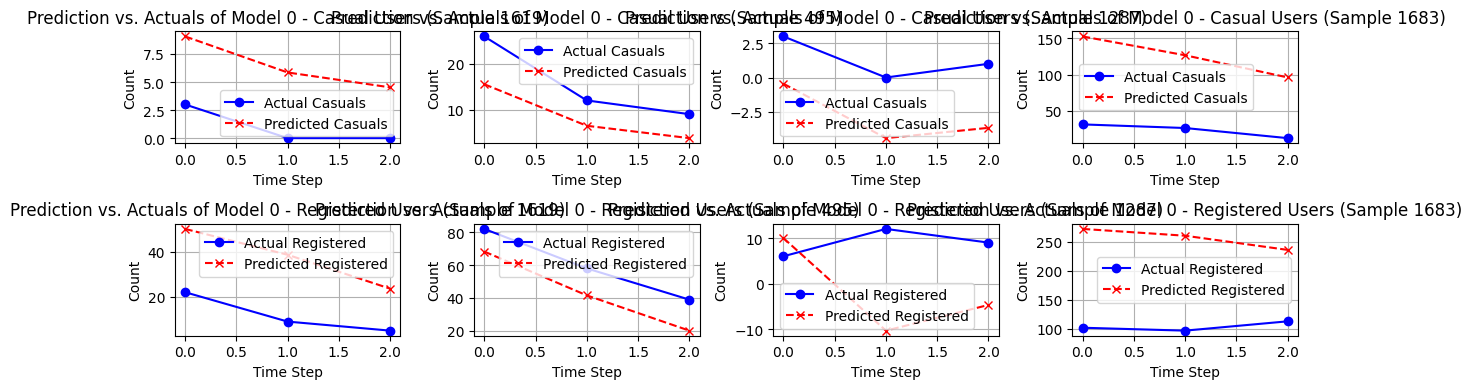


--- Model Performance on Test Set (Denormalized) ---
Casual Users - MAE: 20.47, RMSE: 32.42
Registered Users - MAE: 58.88, RMSE: 86.89


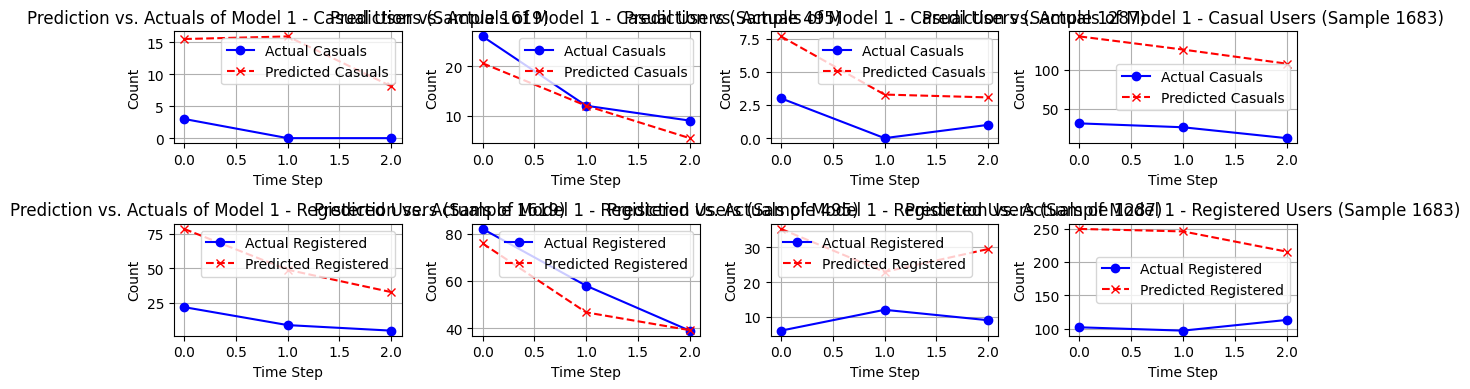


--- Model Performance on Test Set (Denormalized) ---
Casual Users - MAE: 40.90, RMSE: 53.20
Registered Users - MAE: 209.18, RMSE: 267.44


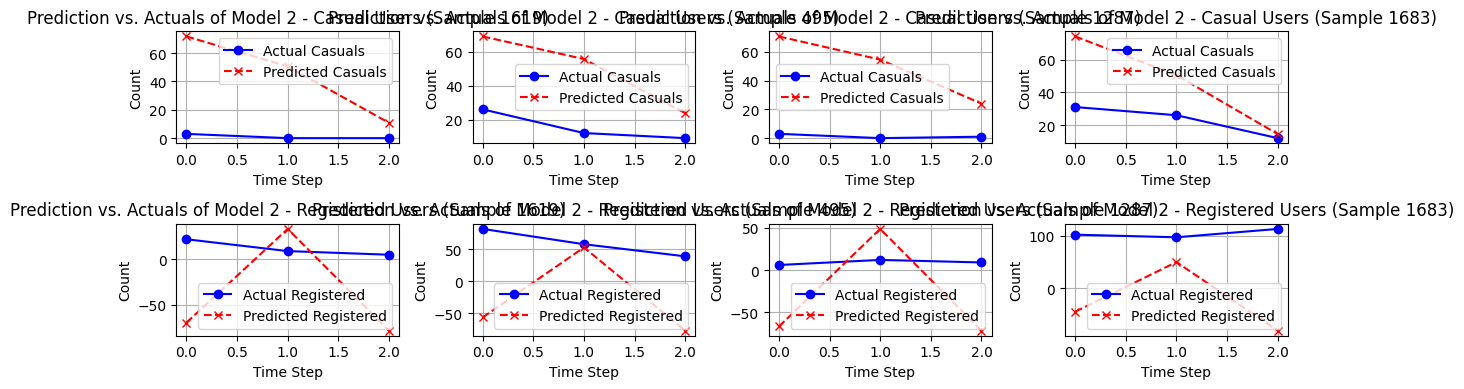

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


indices = np.random.randint(1, 1700, 4).tolist()

for i in range(3):
    # Reshape to a 1D array for metric calculation
    casual_preds_flat = preds[i][0].flatten()
    casual_actuals_flat = actuals[i][0].flatten()
    registered_preds_flat = preds[i][1].flatten()
    registered_actuals_flat = actuals[i][1].flatten()

    casual_mae = mean_absolute_error(casual_actuals_flat, casual_preds_flat)
    casual_rmse = np.sqrt(mean_squared_error(casual_actuals_flat, casual_preds_flat))

    registered_mae = mean_absolute_error(registered_actuals_flat, registered_preds_flat)
    registered_rmse = np.sqrt(mean_squared_error(registered_actuals_flat, registered_preds_flat))

    print("\n--- Model Performance on Test Set (Denormalized) ---")
    print(f"Casual Users - MAE: {casual_mae:.2f}, RMSE: {casual_rmse:.2f}")
    print(f"Registered Users - MAE: {registered_mae:.2f}, RMSE: {registered_rmse:.2f}")

    
# You can change the index to view different samples
    plot_predictions(           
        preds=preds[i],          
        actuals=actuals[i],
        sample_indices=indices, # should send exactly 4 indices
        title="Prediction vs. Actuals of Model "+str(i)
        )

